<a href="https://colab.research.google.com/github/AmberG08/GOSLING_Amber_MEngCapstone/blob/master/glc_lstm6_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, sys
from google.colab import drive
#drive.mount('/content/mnt')
#nb_path = '/content/notebooks'
#os.symlink('/content/mnt/My Drive/Capstone', nb_path)
##sys.path.insert(0, nb_path)  # or append(nb_path)

!pip install scikeras[tensorflow]
!pip install mapie

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 974.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 16.6 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
    

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,  r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from scikeras.wrappers import KerasRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, GRU
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

from mapie.regression import MapieRegressor

np.random.seed(7)
tf.random.set_seed(7)

'''Load in file'''
df_main = pd.read_csv('/content/drive/MyDrive/Capstone/CleanedData.csv')

'''Cut out first ~5000 data points'''
df_main['Timestamp'] = pd.to_datetime(df_main['Timestamp'], format='%d/%m/%Y %H:%M')
cut_date_time = pd.to_datetime('2021-04-30 14:45:00')
filtered_df = df_main[df_main['Timestamp'] >= cut_date_time]

filtered_df=filtered_df.drop('Timestamp', axis=1)
filtered_df=filtered_df.drop('VCC', axis=1)

'''Set target variable'''
#y = filtered_df['CEDEX - GLC3B'] #Target variable
#X = filtered_df.drop(['CEDEX - GLC3B'], axis=1)

X_df = filtered_df#[['Pred (X) 3 PV - O2 Sparge','CEDEX - GLC3B', 'Added Volume', 'Total Volume']]
y_df = filtered_df[[ 'CEDEX - GLC3B']]

actuals = y_df.to_numpy()

X_scaler = MinMaxScaler(feature_range=(0,1)).fit(X_df)
y_scaler = MinMaxScaler(feature_range=(0,1)).fit(y_df)

X_df = X_scaler.fit_transform(X_df)
y_df = y_scaler.fit_transform(y_df)


def df_to_X_y(df, window_size):
  df_as_np = df#.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]]] #[a] wraps the row in brackets
    X.append(row)
    label = df_as_np[i+window_size][10]
    y.append(label)
  return np.array(X), np.array(y)

print('Windowing Function in progress')

WINDOW_SIZE = 1
X1, y1 = df_to_X_y(X_df, WINDOW_SIZE)

print(X1.shape)
print(y1.shape)

# split into train and test sets
train_size = int(len(X_df) * 0.70)
test_size = len(X_df) - train_size

X_train, y_train = X1[0:train_size], y1[0:train_size]
X_test, y_test = X1[train_size:len(X_df)], y1[train_size:len(X_df)]

model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE, 14))) #InputLayer((time_steps, features)
model1.add(LSTM(64)) #Change to GRU as needed
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

'''Compiling the model'''
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

'''Mapie'''
lstm_model=KerasRegressor(build_fn=model1, epochs=10, batch_size=64) #, callbacks=[cp1])
#lstm_model.fit(X_train, y_train)
#print("\nScikeras model fitted")

mapie_regressor = MapieRegressor(estimator=lstm_model, method='plus')
mapie_regressor = mapie_regressor.fit(X_train, y_train)
print("\n Mapie model fitted")




Windowing Function in progress
(9914, 1, 14)
(9914,)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 64)                  │          20,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,753 (81.07 KB)

 Trainable params: 20,753 (81.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 16 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0401 - root_mean_squared_error: 0.1879
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.4642e-04 - root_mean_squared_error: 0.0211
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.5267e-04 - root_mean_squared_error: 0.0157
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5878e-04 - root_mean_squared_error: 0.0157
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.4946e-04 - root_mean_squared_error: 0.0155
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5966e-04 - root_mean_squared_error: 0.0158
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6396e-04 - root_mean_squared_error: 0.0160
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.6344e-04 - root_mean_squared_error: 0.0159
Epoch 9/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.6567e-04 - root_mean_squared_error: 0.0160
Epoch 10/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6006e-0

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 16 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0538 - root_mean_squared_error: 0.2184
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.1463e-04 - root_mean_squared_error: 0.0282
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9080e-04 - root_mean_squared_error: 0.0213
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.6143e-04 - root_mean_squared_error: 0.0204
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4131e-04 - root_mean_squared_error: 0.0198
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3464e-04 - root_mean_squared_error: 0.0196
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2806e-04 - root_mean_squared_error: 0.0194
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1728e-04 - root_mean_squared_error: 0.0191
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0898e-04 - root_mean_squared_error: 0.0189
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1351e-04 - root_mean_square

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 16 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0554 - root_mean_squared_error: 0.2210
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2578e-04 - root_mean_squared_error: 0.0248
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8350e-04 - root_mean_squared_error: 0.0191
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8053e-04 - root_mean_squared_error: 0.0189
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4979e-04 - root_mean_squared_error: 0.0180
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4648e-04 - root_mean_squared_error: 0.0179
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.5749e-04 - root_mean_squared_error: 0.0183
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5857e-04 - root_mean_squared_error: 0.0183
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8486e-04 - root_mean_squared_error: 0.0191
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7954e-04 - root_mean_square

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 16 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0527 - root_mean_squared_error: 0.2156
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2566e-04 - root_mean_squared_error: 0.0229
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1283e-04 - root_mean_squared_error: 0.0142
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9076e-04 - root_mean_squared_error: 0.0131
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8483e-04 - root_mean_squared_error: 0.0129
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8274e-04 - root_mean_squared_error: 0.0128
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7925e-04 - root_mean_squared_error: 0.0128
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8064e-04 - root_mean_squared_error: 0.0128
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.8686e-04 - root_mean_squared_error: 0.0132
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.9045e-04 - root_mean_square

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 16 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0528 - root_mean_squared_error: 0.2160
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.6268e-04 - root_mean_squared_error: 0.0257
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7906e-04 - root_mean_squared_error: 0.0161
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5405e-04 - root_mean_squared_error: 0.0152
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5240e-04 - root_mean_squared_error: 0.0151
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5963e-04 - root_mean_squared_error: 0.0154
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6050e-04 - root_mean_squared_error: 0.0155
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5499e-04 - root_mean_squared_error: 0.0153
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5278e-04 - root_mean_squared_error: 0.0152
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4973e-04 - root_mean_square

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 16 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0562 - root_mean_squared_error: 0.2223
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1526e-04 - root_mean_squared_error: 0.0265
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3625e-04 - root_mean_squared_error: 0.0203
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3176e-04 - root_mean_squared_error: 0.0202
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6075e-04 - root_mean_squared_error: 0.0209
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4600e-04 - root_mean_squared_error: 0.0205
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3804e-04 - root_mean_squared_error: 0.0203
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2115e-04 - root_mean_squared_error: 0.0199
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0541e-04 - root_mean_squared_error: 0.0195
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2053e-04 - root_mean_square

In [ ]:
'''Getting Predictions'''
train_predictions = mapie_regressor.predict(X_train).flatten() # Flatten gets rid of inner brackets
#train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
print(train_predictions.shape)

y_pred, y_pis = mapie_regressor.predict(X_test, alpha=[0.05]) #95% confidence level

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
(6940,)
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
train_predictions_copies = np.reshape(train_predictions, (-1, 1))

#train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
#print(train_results['Train Predictions'])

train_predictions = y_scaler.inverse_transform(train_predictions_copies)
LowerBound = y_scaler.inverse_transform(np.reshape(y_pis[:, 0, 0], (-1, 1)))
UpperBound = y_scaler.inverse_transform(np.reshape(y_pis[:, 1, 0], (-1, 1)))
y_pred =  y_scaler.inverse_transform(np.reshape(y_pred, (-1, 1)))
y_test =  y_scaler.inverse_transform(np.reshape(y_test, (-1, 1)))
y_train =  y_scaler.inverse_transform(np.reshape(y_train, (-1, 1)))

#comparison_df = pd.DataFrame({'Actual': y_test[:,0], 'Predicted': y_pred, 'Lower Bound': y_pis[:, 0, 0], 'Upper Bound': y_pis[:, 1, 0]})
#comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Lower Bound': LowerBound, 'Upper Bound': UpperBound})
#sorted_comparison_df = comparison_df.sort_index()

train_index = pd.DataFrame(data=train_predictions).index
test_index = pd.DataFrame(data=y_test).index

'''Find the maximum index from the training set'''
max_train_index = max(train_index)

'''Shift the indexes for validation and test sets'''
test_index_shifted = [index + max_train_index + 1 for index in test_index]

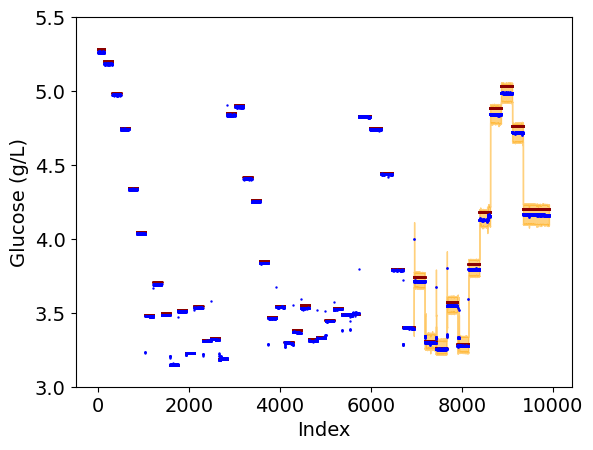


R2 train Score:  0.9971507243676028

R2 test Score:  0.9945135121430974

MSE train:  0.001161651668495044

MSE test:  0.0019416097496284576


In [16]:
"""Plotting"""

plt.xlabel("Index")
plt.ylabel("Glucose (g/L)")
#plt.title("Glucose Predictions against Index, Coverage = 95%")


plt.rcParams.update({'font.size': 14})

#Visualisation
plt.fill_between(test_index_shifted, LowerBound[:,0], UpperBound[:,0], color = 'orange', label = 'Prediction bands', alpha = 0.5)

#scatter plot of index vs glucose
plt.scatter(train_index, actuals[0:train_size], label='Actual values', color='darkred', s=1)
plt.scatter(train_index, train_predictions, label='Predictions', color='blue', s=0.5)

plt.scatter(test_index_shifted, actuals[train_size+1:len(X_df)], color='darkred', s=1)
plt.scatter(test_index_shifted, y_pred[:,0], color = 'blue', s=1)


# legend = plt.legend(loc="lower left")
# legend.get_frame().set_alpha(None)
# legend.legend_handles[0]._sizes = [30]
# legend.legend_handles[1]._sizes = [30]

ymin, ymax = 3, 5.5
plt.ylim(ymin, ymax)
plt.show()


R2_train = r2_score(y_train, train_predictions)
R2_test = r2_score(y_test, y_pred)

MSE_train = mean_squared_error(y_train, train_predictions)
MSE_test = mean_squared_error(y_test, y_pred)

print('\nR2 train Score: ', R2_train)
print('\nR2 test Score: ', R2_test)
print('\nMSE train: ', MSE_train)
print('\nMSE test: ', MSE_test)

In [17]:
# Concatenating actuals
actuals_concat = actuals[train_size+1:len(X_df)]

# Calculating (Upperbound - Lowerbound)/actuals
cp_metric = ((UpperBound[:,0] - LowerBound[:,0]) / actuals_concat)*100

cp_metric_min = np.min(cp_metric)
cp_metric_max = np.max(cp_metric)
cp_metric_mean = np.mean(cp_metric)

print("Minimum:", round(cp_metric_min,3))
print("Maximum:", round(cp_metric_max,3))
print("Mean:", round(cp_metric_mean,3))

Minimum: 1.729
Maximum: 11.788
Mean: 3.03
